<center><h3>Tree Based Method and Boosting</h3></center>
<center><font size=\"4\">Name: Jiahao Liu<br>Github: Julius-JiahaoLiu</font></center>

In [143]:
!pip install xgboost
!brew install libomp

==> Auto-updating Homebrew...
Adjust how often this is run with HOMEBREW_AUTO_UPDATE_SECS or disable with
HOMEBREW_NO_AUTO_UPDATE. Hide these hints with HOMEBREW_NO_ENV_HINTS (see `man brew`).
==> Downloading https://ghcr.io/v2/homebrew/portable-ruby/portable-ruby/blobs/sha256:e7340e4a1d7cc0f113686e461b93114270848cb14676e9037a1a2ff3b1a0ff32
######################################################################### 100.0%
==> Pouring portable-ruby-3.3.5.arm64_big_sur.bottle.tar.gz
==> Auto-updated Homebrew!
Updated 2 taps (homebrew/core and homebrew/cask).
==> New Formulae
action-docs                jxl-oxide                  python-tk@3.13
afl++                      keep-sorted                python@3.13
aicommit                   kubetail                   recc
ansible-builder            langgraph-cli              repopack
argtable3                  lbfgspp                    rip2
binsider                   libcss                     roxctl
blisp                      libdom            

In [145]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier, plot_tree, _tree
import matplotlib.pyplot as plt
import numpy as np
from sklearn.impute import SimpleImputer
import seaborn as sns
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score, GridSearchCV
import xgboost as xgb

#### 1. Decision Trees as Interpretable Models
(b) Build a decision tree on the whole data set and plot it. 

*This data set is a multi-label data set. Sk-Learn seems to support building multi-label decision trees. Alternatively, you can use the label powerset method to convert it to a multiclass data set. Also, you can use the binary relevance method and build one decision tree for each label. It seems that the label powerset approach is more relevant here. Is that right?*

Answer: we can NOT only build a decision tree with powerset multiclass data, we should also build two seperate decision trees for each label because there might be correlation or data imbalance for these two labels.

In [82]:
column_names = ['a1', 'a2', 'a3', 'a4', 'a5', 'a6', 'd1', 'd2']
def convert_temperature(temp):
    return float(temp.replace(',', '.'))
diagnosis_data = pd.read_csv('../data/diagnosis.csv', header = None, names = column_names, converters = {'a1': convert_temperature})
diagnosis_data.head()

,a1,a2,a3,a4,a5,a6,d1,d2
0,35.5,no,yes,no,no,no,no,no
1,35.9,no,no,yes,yes,yes,yes,no
2,35.9,no,yes,no,no,no,no,no
3,36.0,no,no,yes,yes,yes,yes,no
4,36.0,no,yes,no,no,no,no,no


In [83]:
# Combine the labels using label powerset
diagnosis_data['label'] = diagnosis_data.apply(lambda row: f"{int(row['d1'] == 'yes')}{int(row['d2'] == 'yes')}", axis=1)

# Convert the label to an integer for the decision tree
label_mapping = {'00': 0, '01': 1, '10': 2, '11': 3}
diagnosis_data['label'] = diagnosis_data['label'].map(label_mapping)

# Convert yes/no columns to binary 1/0
pd.set_option('future.no_silent_downcasting', True)
diagnosis_data = diagnosis_data.replace({'yes': 1, 'no': 0})
diagnosis_data['d1'] = diagnosis_data['d1'].astype('int')
diagnosis_data['d2'] = diagnosis_data['d2'].astype('int')

diagnosis_data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120 entries, 0 to 119
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   a1      120 non-null    float64
 1   a2      120 non-null    object 
 2   a3      120 non-null    object 
 3   a4      120 non-null    object 
 4   a5      120 non-null    object 
 5   a6      120 non-null    object 
 6   d1      120 non-null    int64  
 7   d2      120 non-null    int64  
 8   label   120 non-null    int64  
dtypes: float64(1), int64(3), object(5)
memory usage: 8.6+ KB


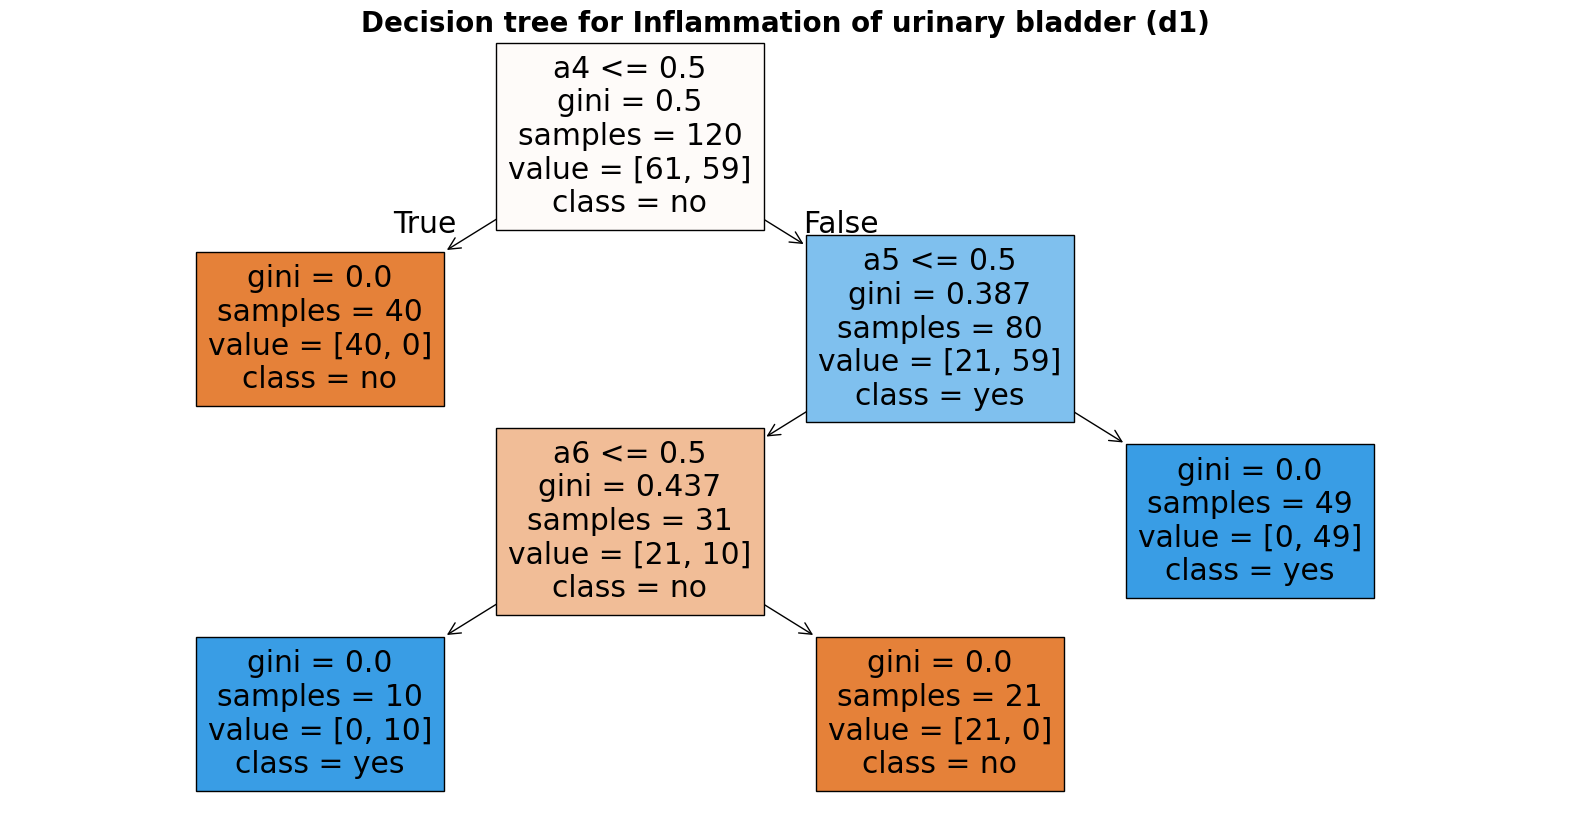

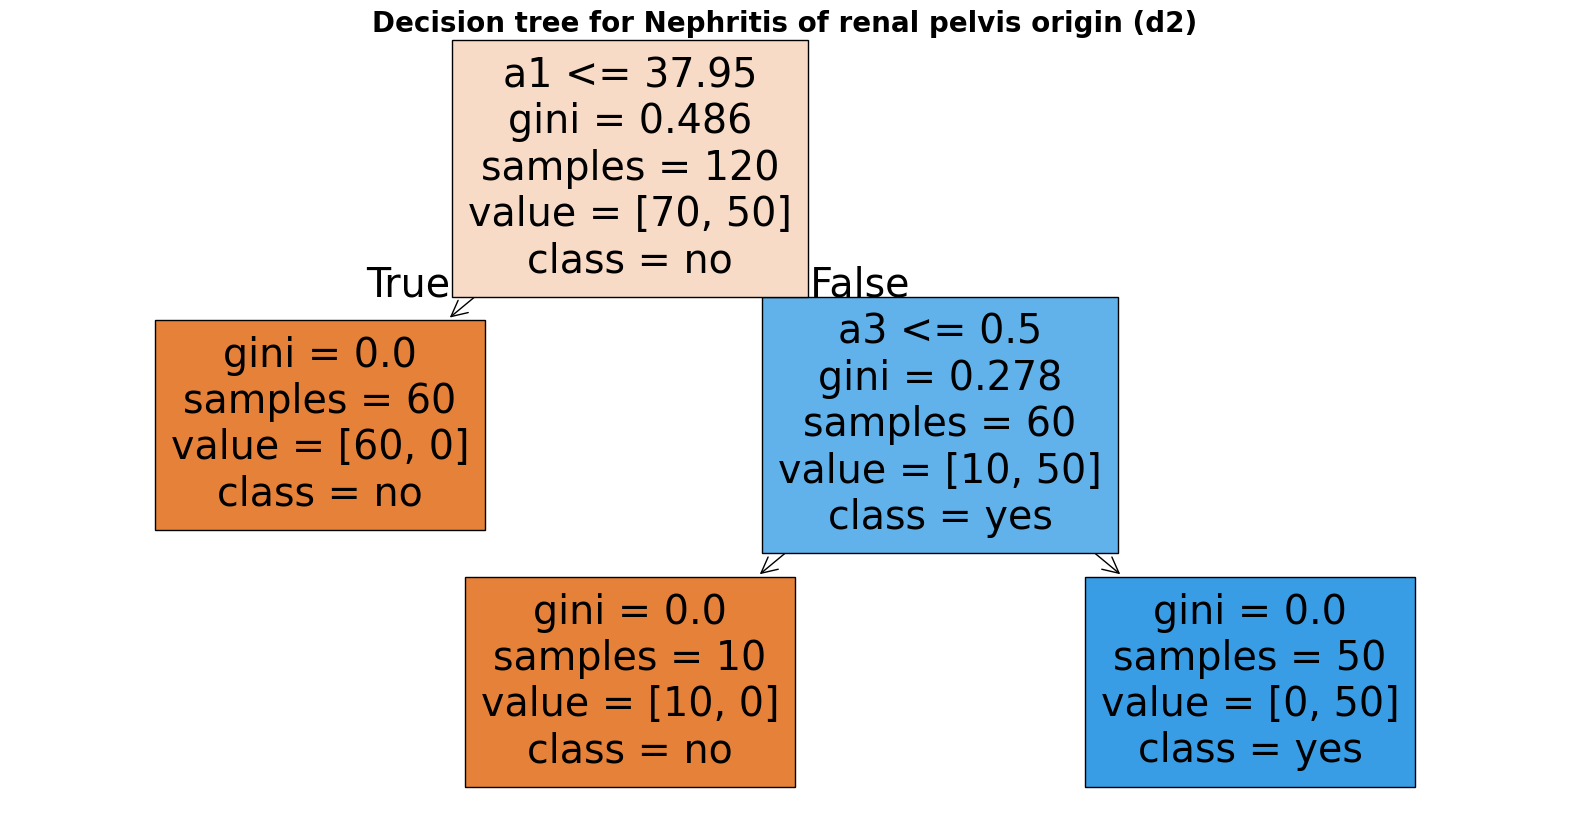

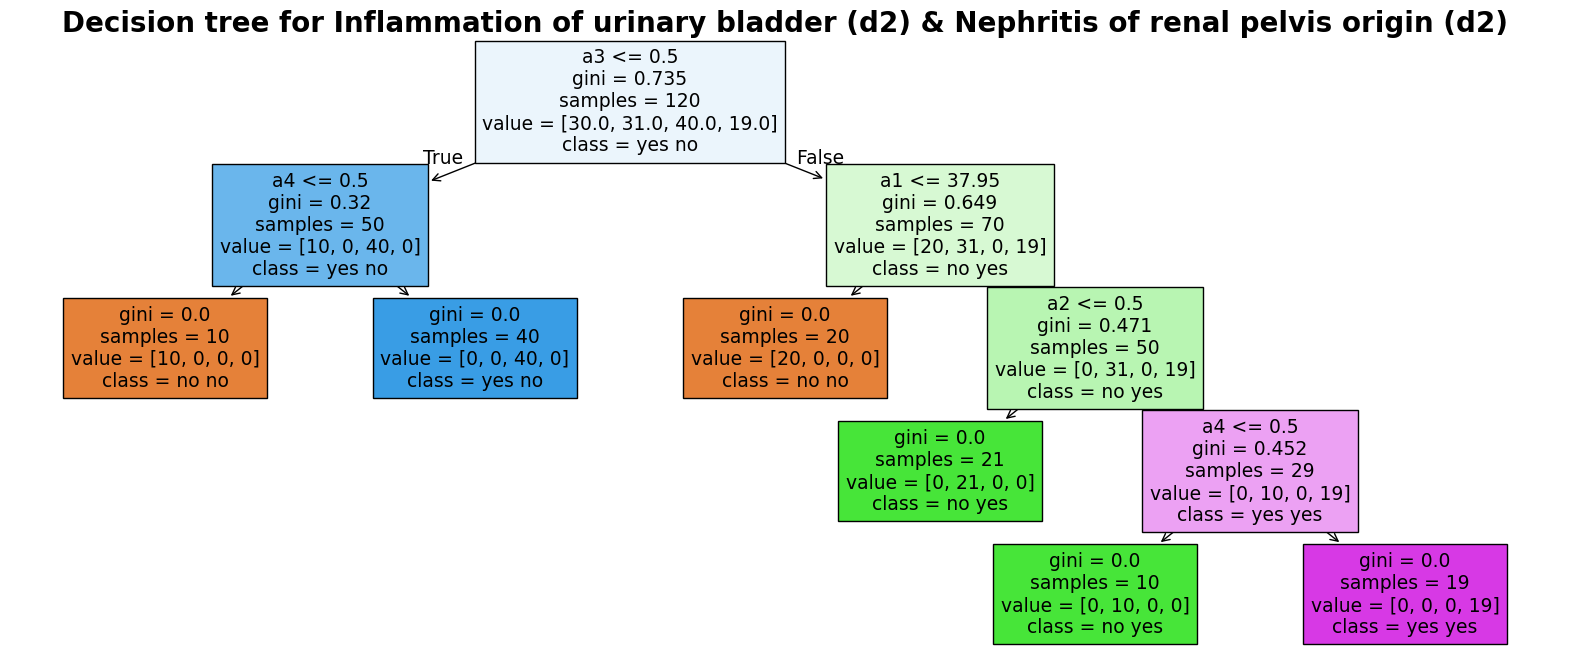

In [88]:
# Separate features and target
X = diagnosis_data.drop(columns=['d1', 'd2', 'label'])
y1 = diagnosis_data['d1']
y2 = diagnosis_data['d2']
y3 = diagnosis_data['label']
# Initialize the decision tree classifier
dt_classifier1 = DecisionTreeClassifier(random_state=42)  # 'random_state' for reproducibility
dt_classifier1.fit(X, y1)
plt.figure(figsize=(20,10))  # Set the figure size for clarity
plot_tree(dt_classifier1, feature_names=X.columns, class_names=['no', 'yes'], filled=True)
plt.title('Decision tree for Inflammation of urinary bladder (d1)', fontsize=20, fontweight='bold')
plt.show()

dt_classifier2 = DecisionTreeClassifier(random_state=42)
dt_classifier2.fit(X, y2)
plt.figure(figsize=(20,10))  # Set the figure size for clarity
plot_tree(dt_classifier2, feature_names=X.columns, class_names=['no', 'yes'], filled=True)
plt.title('Decision tree for Nephritis of renal pelvis origin (d2)', fontsize=20, fontweight='bold')
plt.show()

dt_classifier3 = DecisionTreeClassifier(random_state=42)
dt_classifier3.fit(X, y3)
plt.figure(figsize=(20,8))  # Set the figure size for clarity
plot_tree(dt_classifier3, feature_names=X.columns, class_names=['no no', 'no yes', 'yes no', 'yes yes'], filled=True)
plt.title('Decision tree for Inflammation of urinary bladder (d2) & Nephritis of renal pelvis origin (d2)', fontsize=20, fontweight='bold')
plt.show()

(c) Convert the decision rules into a set of IF-THEN rules.

In [95]:
def print_decision_tree_rules(tree, feature_names, class_names=None):
    left = tree.tree_.children_left
    right = tree.tree_.children_right
    threshold = tree.tree_.threshold
    value = tree.tree_.value
    features = [feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined" for i in tree.tree_.feature]
    print("IF-THEN rules of Decision Tree for {}:".format(class_names))
    def recurse(node, depth):
        indent = "  " * depth
        if threshold[node] != _tree.TREE_UNDEFINED:
            name = features[node]
            threshold_value = threshold[node]
            print(f"{indent}if {name} <= {threshold_value}:")
            recurse(left[node], depth + 1)
            print(f"{indent}else:  # if {name} > {threshold_value}")
            recurse(right[node], depth + 1)
        else:
            # Determine the class with the largest probability (or count)
            class_index = np.argmax(value[node])
            print(f"{indent}return {class_index}")
    recurse(0, 0)

print_decision_tree_rules(dt_classifier1, X.columns, 'Inflammation of urinary bladder')

IF-THEN rules of Decision Tree for Inflammation of urinary bladder:
if a4 <= 0.5:
  return 0
else:  # if a4 > 0.5
  if a5 <= 0.5:
    if a6 <= 0.5:
      return 1
    else:  # if a6 > 0.5
      return 0
  else:  # if a5 > 0.5
    return 1


In [96]:
print_decision_tree_rules(dt_classifier2, X.columns, 'Nephritis of renal pelvis origin')

IF-THEN rules of Decision Tree for Nephritis of renal pelvis origin:
if a1 <= 37.95000076293945:
  return 0
else:  # if a1 > 37.95000076293945
  if a3 <= 0.5:
    return 0
  else:  # if a3 > 0.5
    return 1


In [97]:
print_decision_tree_rules(dt_classifier3, X.columns, 'Inflammation of urinary bladder & Nephritis of renal pelvis origin')

IF-THEN rules of Decision Tree for Inflammation of urinary bladder & Nephritis of renal pelvis origin:
if a3 <= 0.5:
  if a4 <= 0.5:
    return 0
  else:  # if a4 > 0.5
    return 2
else:  # if a3 > 0.5
  if a1 <= 37.95000076293945:
    return 0
  else:  # if a1 > 37.95000076293945
    if a2 <= 0.5:
      return 1
    else:  # if a2 > 0.5
      if a4 <= 0.5:
        return 1
      else:  # if a4 > 0.5
        return 3


(d) Use cost-complexity pruning to find a minimal decision tree and a set of decision rules with high interpretability.

In [107]:
def use_cost_complexity_to_prune_tree(tree, X, y, class_name):
    # Determine the optimal alpha using cost complexity pruning
    path = tree.cost_complexity_pruning_path(X, y)
    ccp_alphas, impurities = path.ccp_alphas, path.impurities
    print(f"Number of nodes in the tree: {tree.tree_.node_count}")
    print(f"ccp_alphas: {ccp_alphas}")
    print(f"impurities: {impurities}")

    # Plotting the effective alphas
    plt.figure(figsize=(8, 6))
    plt.plot(ccp_alphas, impurities, marker='o', drawstyle="steps-post")
    plt.xlabel("Effective Alpha")
    plt.ylabel("Total Impurity of Leaves")
    plt.title(f"Total Impurity vs effective alpha for training set ({class_name})")
    plt.show()

    # Prune the tree using the optimal alpha, here we chose the second smallest alpha with second lowest impurity
    pruned_dt_classifier = DecisionTreeClassifier(random_state=42, ccp_alpha=ccp_alphas[1])
    pruned_dt_classifier.fit(X, y)
    # Use the earlier method to convert it to rules
    print(f"Number of nodes in the pruned tree for {class_name}: {pruned_dt_classifier.tree_.node_count}")
    print_decision_tree_rules(pruned_dt_classifier, X.columns, class_name)

Number of nodes in the tree: 7
ccp_alphas: [0.         0.11290323 0.14522177 0.24173611]
impurities: [0.         0.11290323 0.258125   0.49986111]


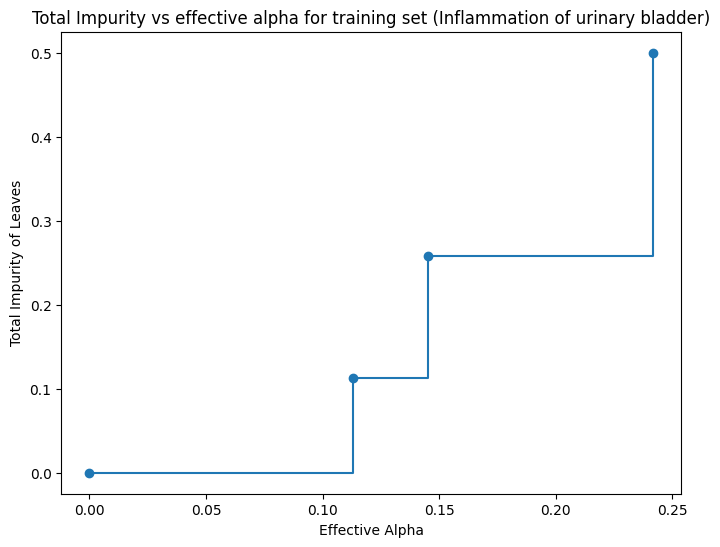

Number of nodes in the pruned tree for Inflammation of urinary bladder: 5
IF-THEN rules of Decision Tree for Inflammation of urinary bladder:
if a4 <= 0.5:
  return 0
else:  # if a4 > 0.5
  if a5 <= 0.5:
    return 0
  else:  # if a5 > 0.5
    return 1


In [108]:
use_cost_complexity_to_prune_tree(dt_classifier1, X, y1, 'Inflammation of urinary bladder')

Number of nodes in the tree: 5
ccp_alphas: [0.         0.13888889 0.34722222]
impurities: [0.         0.13888889 0.48611111]


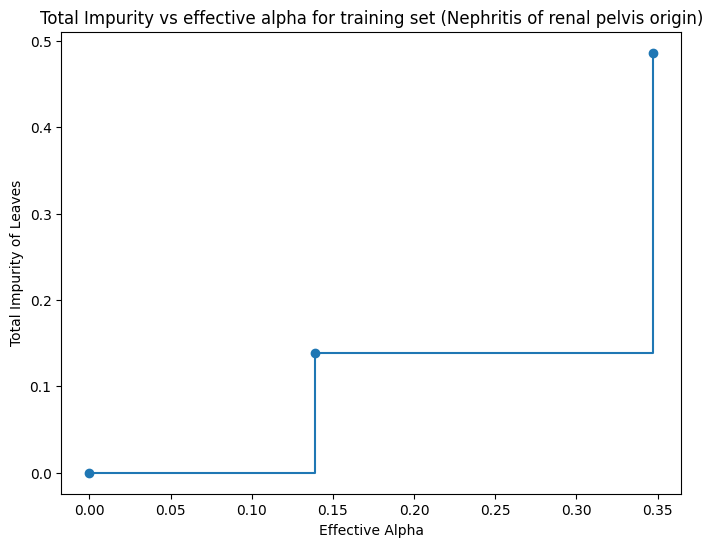

Number of nodes in the pruned tree for Nephritis of renal pelvis origin: 3
IF-THEN rules of Decision Tree for Nephritis of renal pelvis origin:
if a1 <= 37.95000076293945:
  return 0
else:  # if a1 > 37.95000076293945
  return 1


In [109]:
use_cost_complexity_to_prune_tree(dt_classifier2, X, y2, 'Nephritis of renal pelvis origin')

Number of nodes in the tree: 11
ccp_alphas: [0.         0.09816667 0.13333333 0.182      0.22291667]
impurities: [0.         0.19633333 0.32966667 0.51166667 0.73458333]


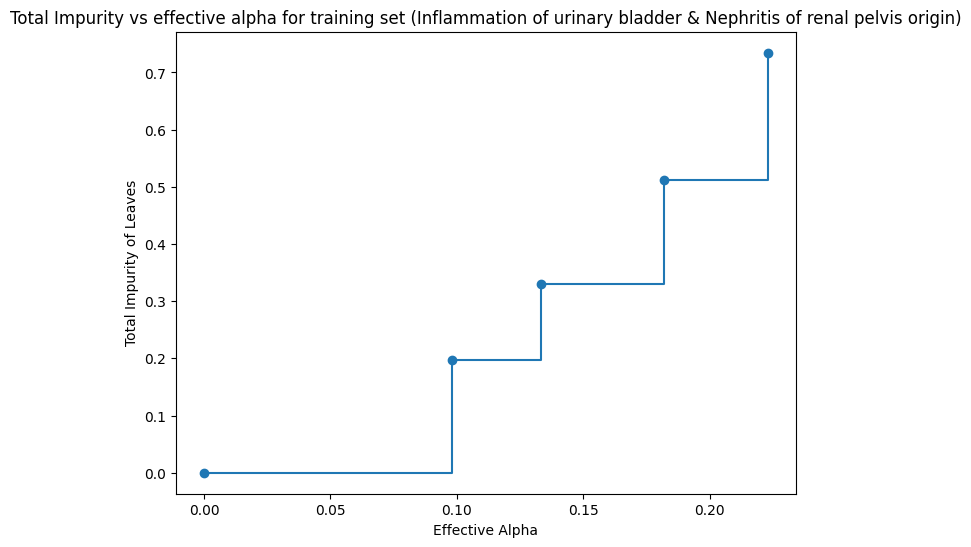

Number of nodes in the pruned tree for Inflammation of urinary bladder & Nephritis of renal pelvis origin: 7
IF-THEN rules of Decision Tree for Inflammation of urinary bladder & Nephritis of renal pelvis origin:
if a3 <= 0.5:
  if a4 <= 0.5:
    return 0
  else:  # if a4 > 0.5
    return 2
else:  # if a3 > 0.5
  if a1 <= 37.95000076293945:
    return 0
  else:  # if a1 > 37.95000076293945
    return 1


In [110]:
use_cost_complexity_to_prune_tree(dt_classifier3, X, y3, 'Inflammation of urinary bladder & Nephritis of renal pelvis origin')

#### 2. The LASSO and Boosting for Regression
(a) Download the Communities and Crime data. Use the first 1495 rows of data as the training set and the rest as the test set. 

(b) The data set has missing values. Use a data imputation technique to deal with the missing values in the data set. The data description mentions some features are nonpredictive. Ignore those features.

In [123]:
# Define the column names as described
column_names = [
    "state", "county", "community", "communityname", "fold",
    "population", "householdsize", "racepctblack", "racePctWhite",
    "racePctAsian", "racePctHisp", "agePct12t21", "agePct12t29",
    "agePct16t24", "agePct65up", "numbUrban", "pctUrban", "medIncome", 
    "pctWWage", "pctWFarmSelf", "pctWInvInc", "pctWSocSec", "pctWPubAsst", 
    "pctWRetire", "medFamInc", "perCapInc", "whitePerCap", "blackPerCap", 
    "indianPerCap", "AsianPerCap", "OtherPerCap", "HispPerCap", "NumUnderPov",
    "PctPopUnderPov", "PctLess9thGrade", "PctNotHSGrad", "PctBSorMore", 
    "PctUnemployed", "PctEmploy", "PctEmplManu", "PctEmplProfServ", 
    "PctOccupManu", "PctOccupMgmtProf", "MalePctDivorce", "MalePctNevMarr",
    "FemalePctDiv", "TotalPctDiv", "PersPerFam", "PctFam2Par", "PctKids2Par",
    "PctYoungKids2Par", "PctTeen2Par", "PctWorkMomYoungKids", "PctWorkMom",
    "NumIlleg", "PctIlleg", "NumImmig", "PctImmigRecent", "PctImmigRec5",
    "PctImmigRec8", "PctImmigRec10", "PctRecentImmig", "PctRecImmig5", 
    "PctRecImmig8", "PctRecImmig10", "PctSpeakEnglOnly", "PctNotSpeakEnglWell",
    "PctLargHouseFam", "PctLargHouseOccup", "PersPerOccupHous", 
    "PersPerOwnOccHous", "PersPerRentOccHous", "PctPersOwnOccup", 
    "PctPersDenseHous", "PctHousLess3BR", "MedNumBR", "HousVacant", 
    "PctHousOccup", "PctHousOwnOcc", "PctVacantBoarded", "PctVacMore6Mos", 
    "MedYrHousBuilt", "PctHousNoPhone", "PctWOFullPlumb", "OwnOccLowQuart", 
    "OwnOccMedVal", "OwnOccHiQuart", "RentLowQ", "RentMedian", "RentHighQ", 
    "MedRent", "MedRentPctHousInc", "MedOwnCostPctInc", 
    "MedOwnCostPctIncNoMtg", "NumInShelters", "NumStreet", "PctForeignBorn", 
    "PctBornSameState", "PctSameHouse85", "PctSameCity85", "PctSameState85", 
    "LemasSwornFT", "LemasSwFTPerPop", "LemasSwFTFieldOps", 
    "LemasSwFTFieldPerPop", "LemasTotalReq", "LemasTotReqPerPop", 
    "PolicReqPerOffic", "PolicPerPop", "RacialMatchCommPol", "PctPolicWhite", 
    "PctPolicBlack", "PctPolicHisp", "PctPolicAsian", "PctPolicMinor", 
    "OfficAssgnDrugUnits", "NumKindsDrugsSeiz", "PolicAveOTWorked", 
    "LandArea", "PopDens", "PctUsePubTrans", "PolicCars", "PolicOperBudg", 
    "LemasPctPolicOnPatr", "LemasGangUnitDeploy", "LemasPctOfficDrugUn", 
    "PolicBudgPerPop", "ViolentCrimesPerPop"
]

# Read the CSV without headers
df = pd.read_csv('../data/communities.csv', header=None, names=column_names, na_values='?')

# Drop non-predictive columns
non_predictive_columns = ["state", "county", "community", "communityname", "fold"]
df = df.drop(columns=non_predictive_columns)

# Handle missing values by imputing mean
imputer = SimpleImputer(strategy='mean')
df = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)

# Split the data: first 1495 rows for training
train_df = df.iloc[:1495]
test_df = df.iloc[1495:]

# Check shapes to verify
print("Training data shape:", train_df.shape)
print("Testing data shape:", test_df.shape)

Training data shape: (1495, 123)
Testing data shape: (499, 123)


(c) Plot a correlation matrix for the features in the data set.

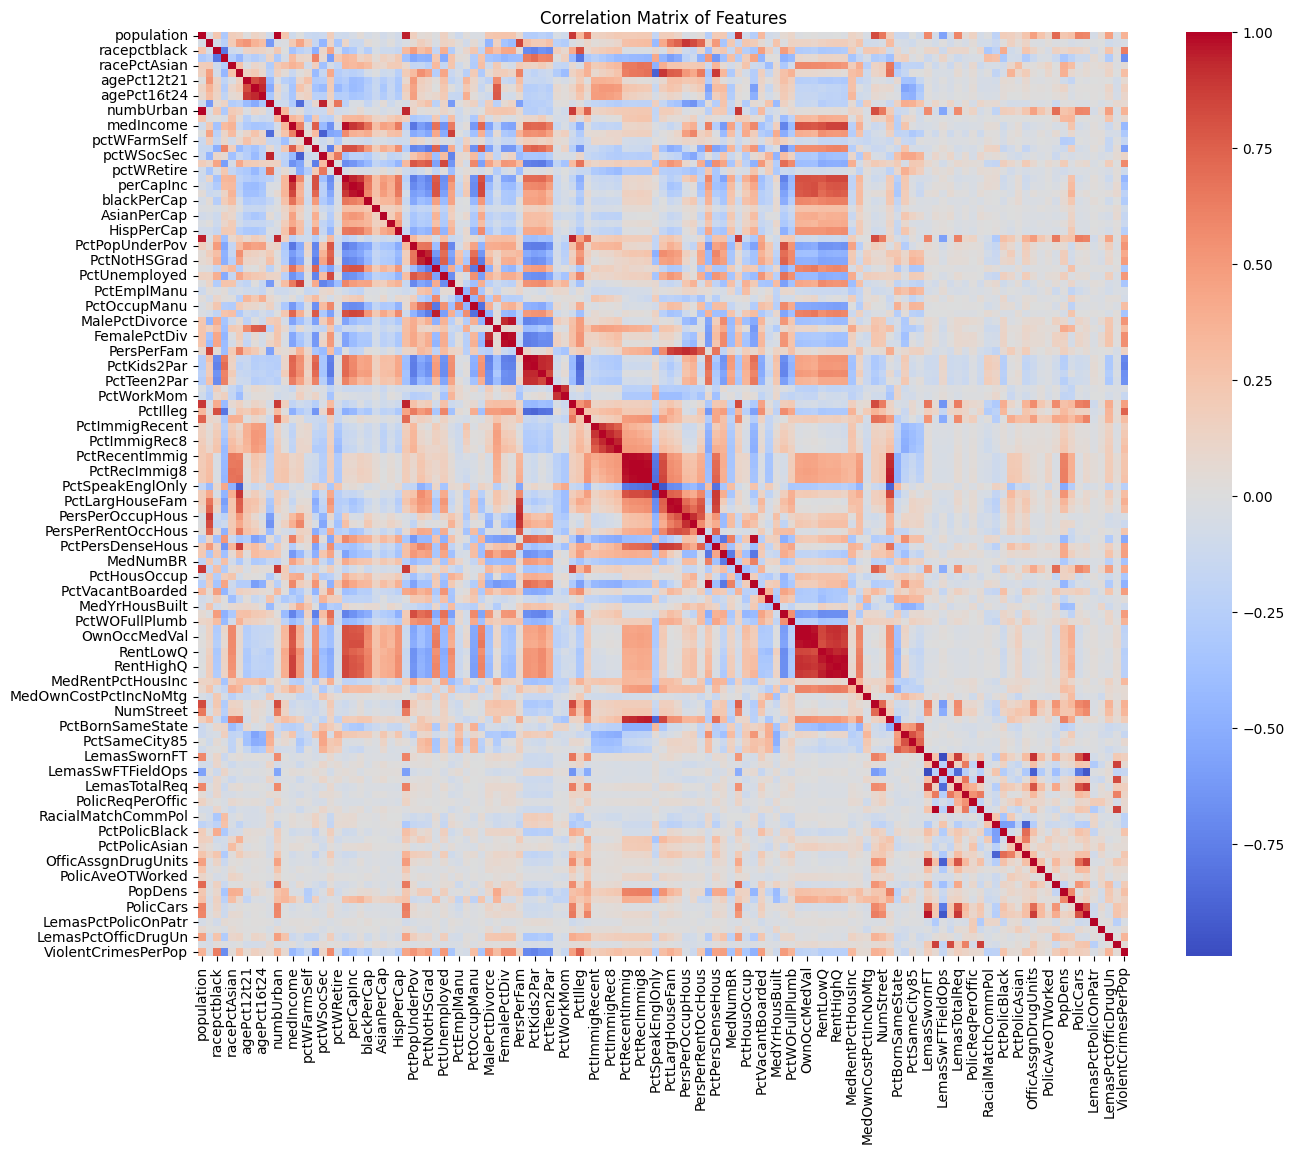

In [124]:
# Calculate the correlation matrix
correlation_matrix = df.corr()

# Plot the heatmap
plt.figure(figsize=(15, 12))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', fmt=".2f", cbar=True)
plt.title("Correlation Matrix of Features")
plt.show()

(d) Calculate the Coefficient of Variation CV for each feature, where CV = s/m, in which s is sample standard deviation and m is sample mean.

In [125]:
# Calculate the Coefficient of Variation (CV) for each feature
cv = train_df.std() / train_df.mean()

# Print the CV for each feature
print(cv)

population             2.241105
householdsize          0.355800
racepctblack           1.428885
racePctWhite           0.330213
racePctAsian           1.359100
                         ...   
LemasPctPolicOnPatr    0.117988
LemasGangUnitDeploy    0.371002
LemasPctOfficDrugUn    2.552946
PolicBudgPerPop        0.320035
ViolentCrimesPerPop    0.987909
Length: 123, dtype: float64


(e) Pick $\lfloor\sqrt{128}\rfloor$ features with highest CV , and make scatter plots and box plots for them. Can you draw conclusions about significance of those features, just by the scatter plots?

Answer: NO!

Significance from Scatter Plots: Scatter plots just provide a visual indication of the relationship between each selected feature and ViolentCrimesPerPop. They can suggest trends such as positive or negative correlations, but they do not provide statistical significance. **Conclusions about a feature's significance require statistical analysis** (such as hypothesis testing or feature importance in predictive models).

As professor taughted in lectuers, **Correlation Does Not Imply Causation** Even if there appears to be a trend in the scatter plot, it does not mean this feature causes changes in the target variable. These plots only consider one feature in relation to the target at a time. Real-world data often involves multivariate relationships.

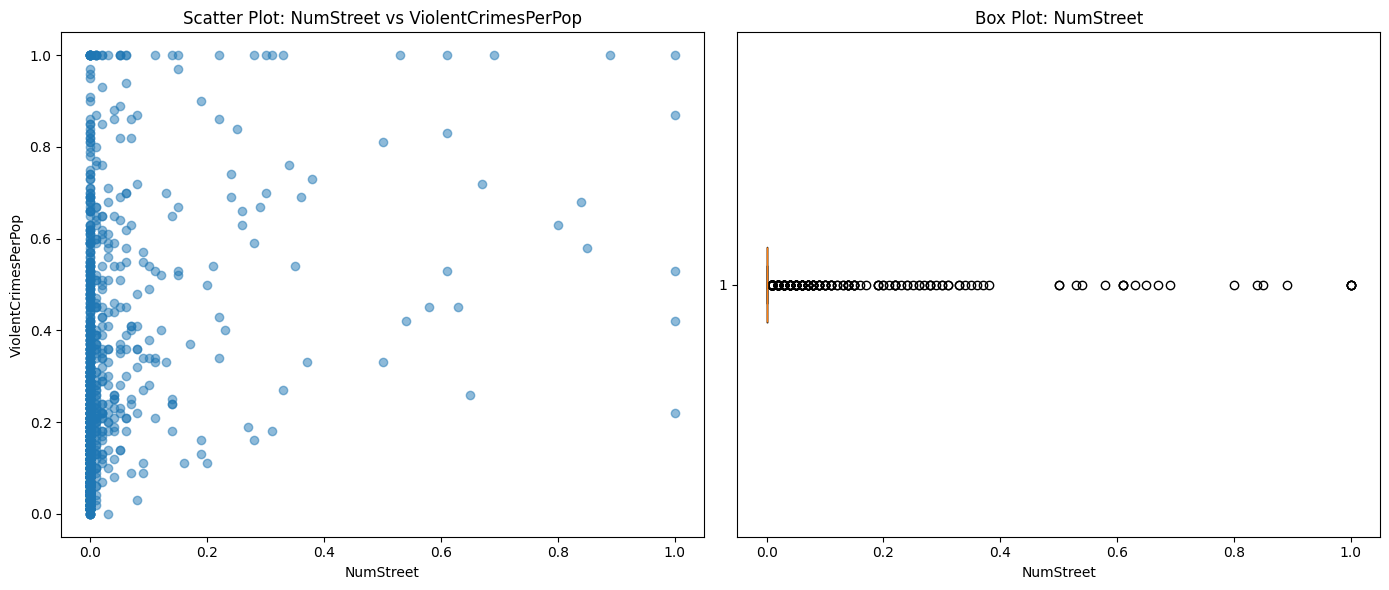

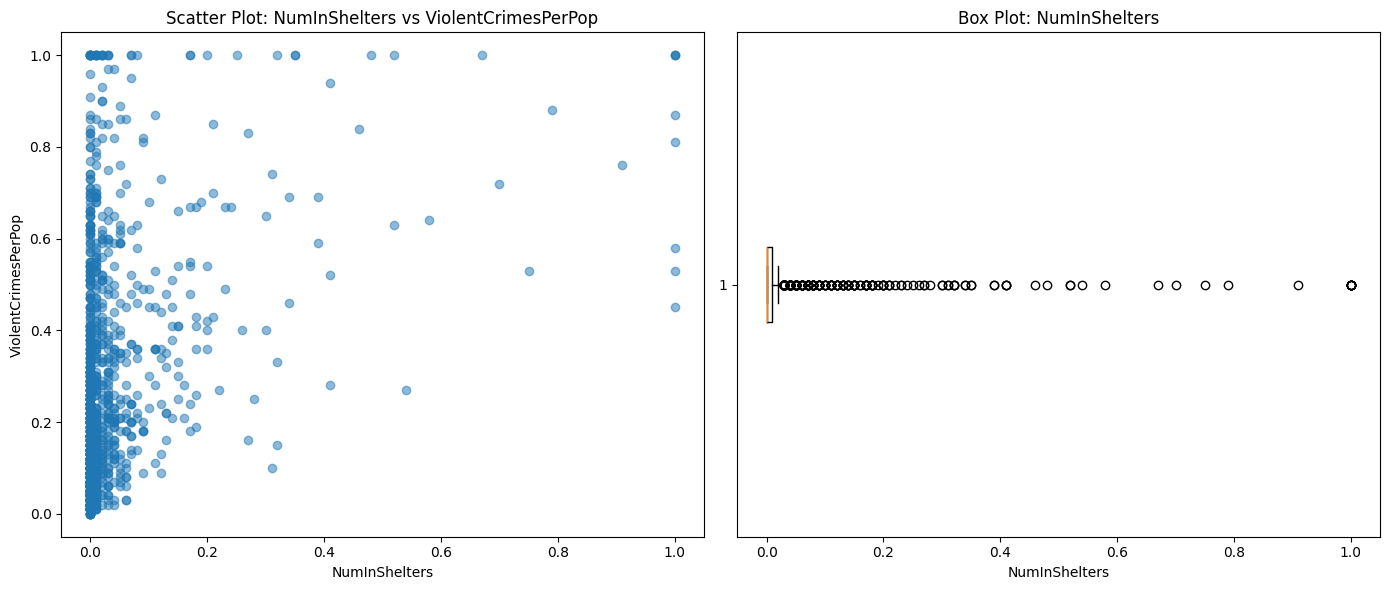

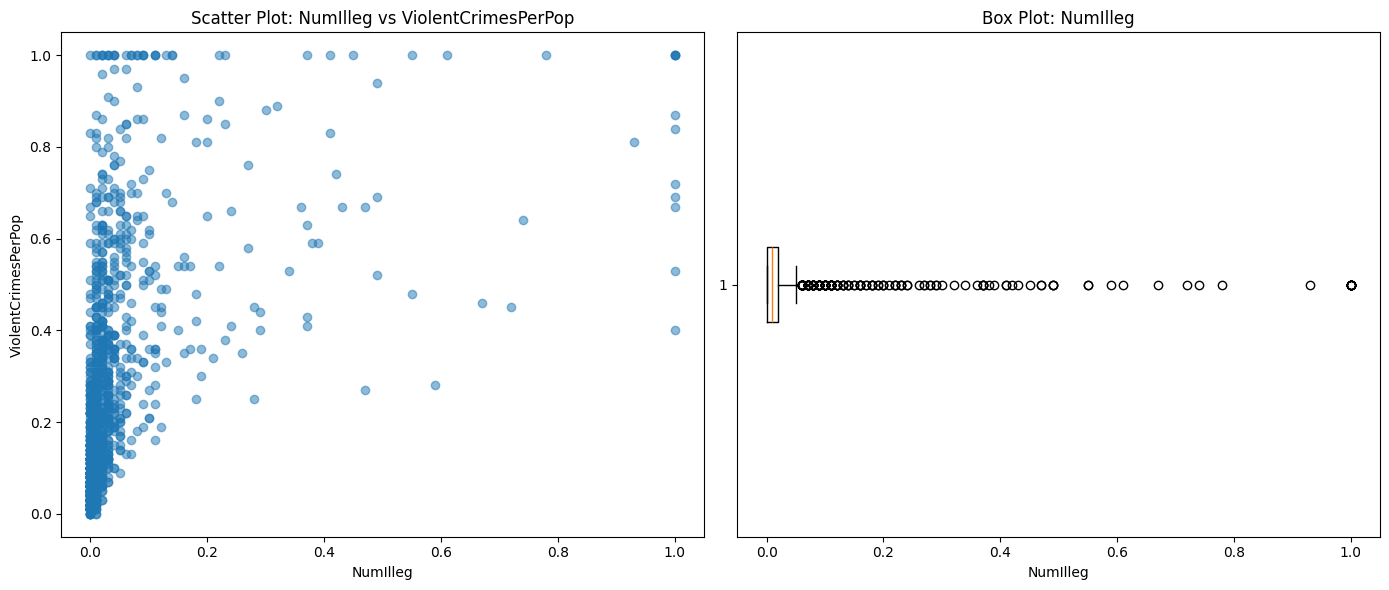

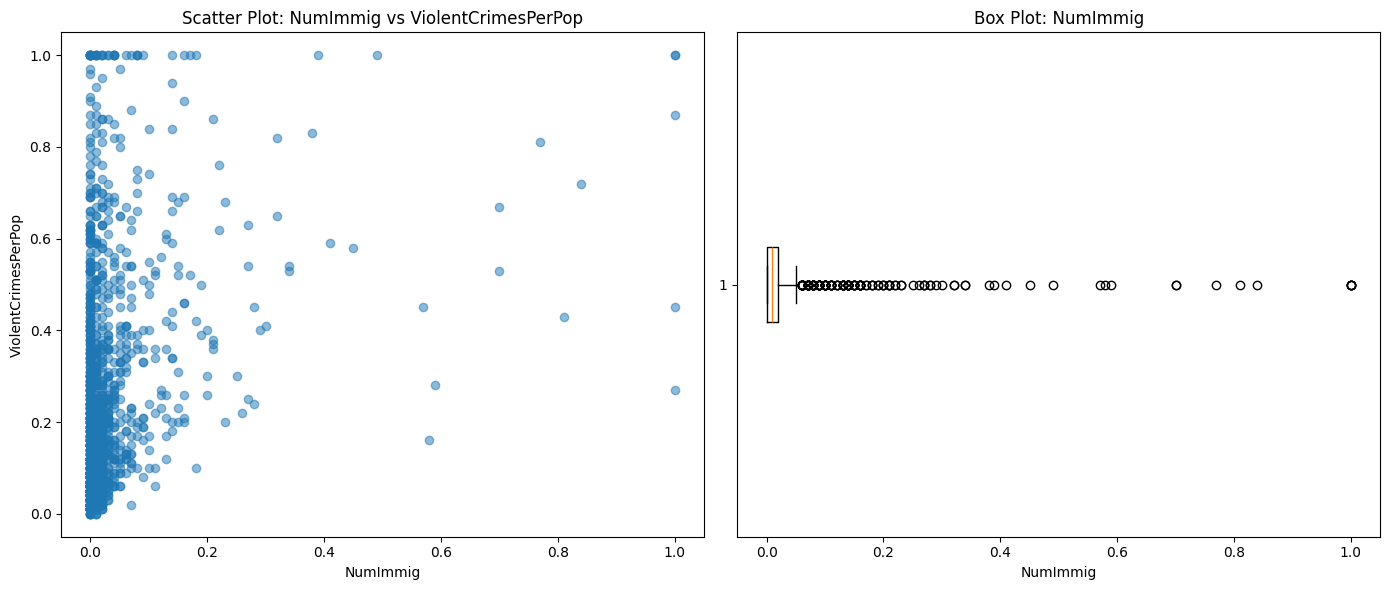

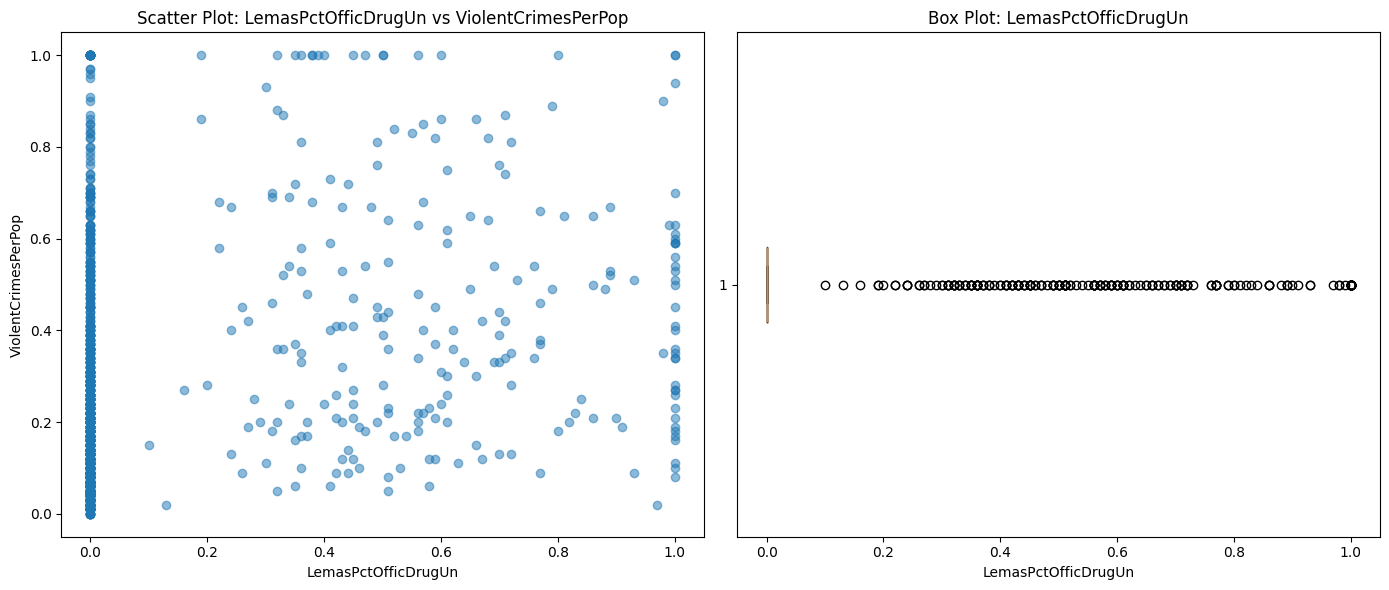

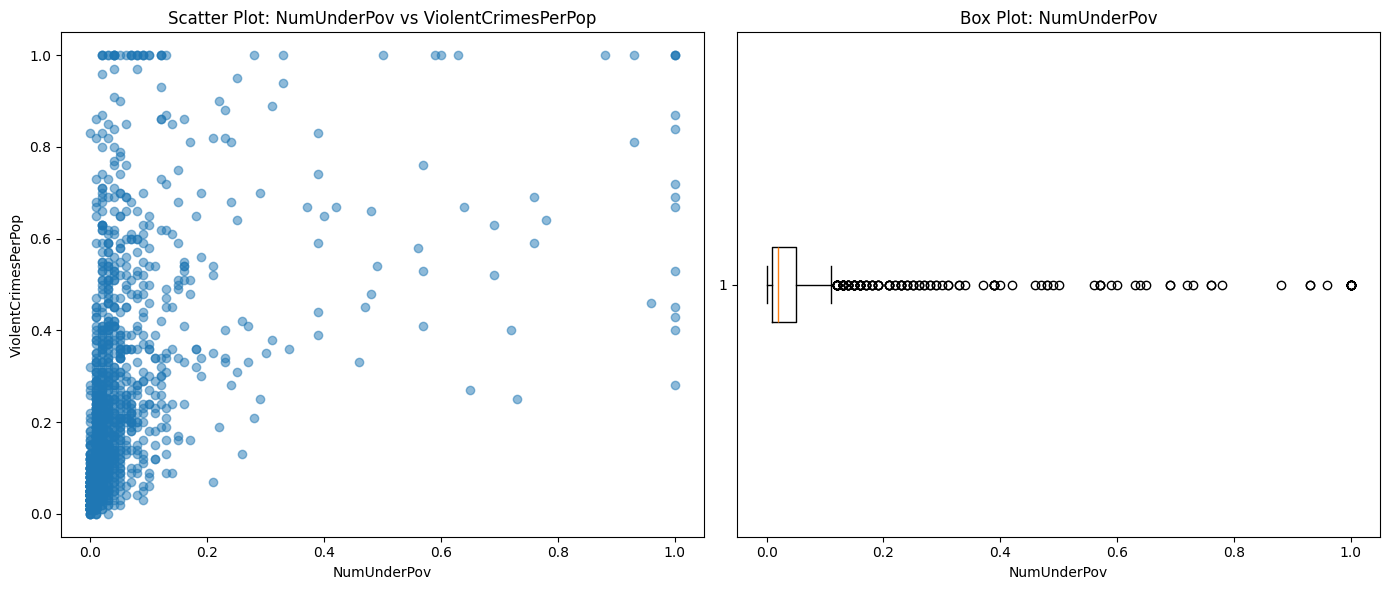

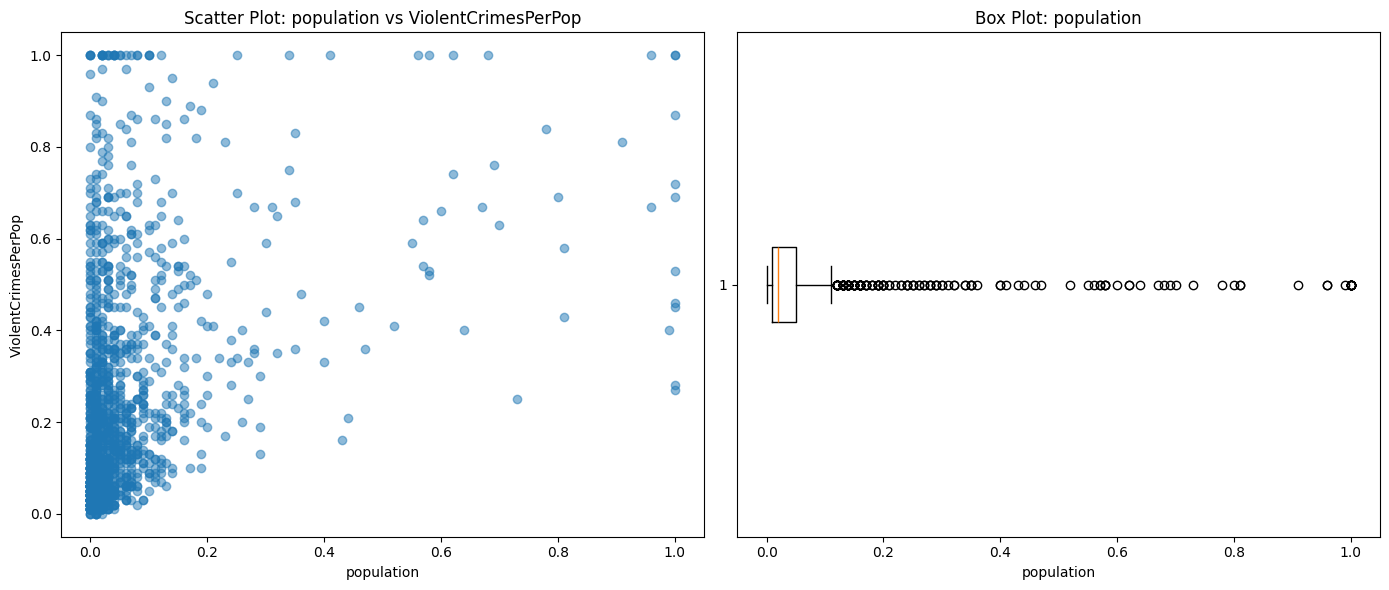

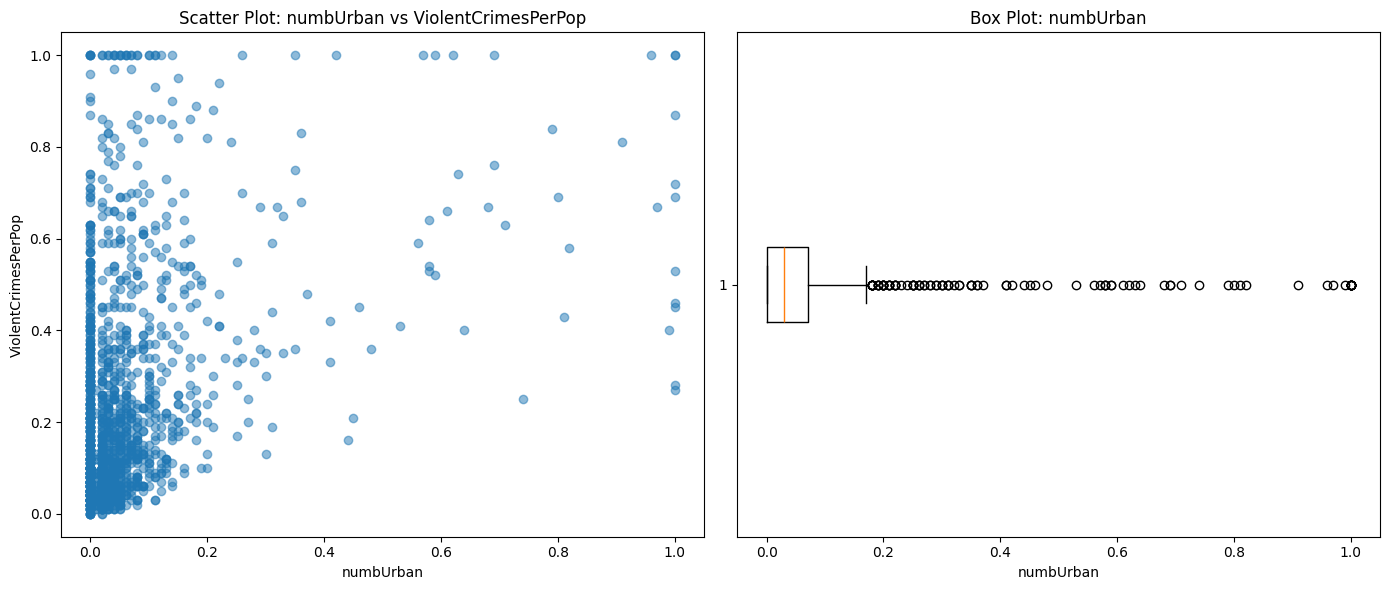

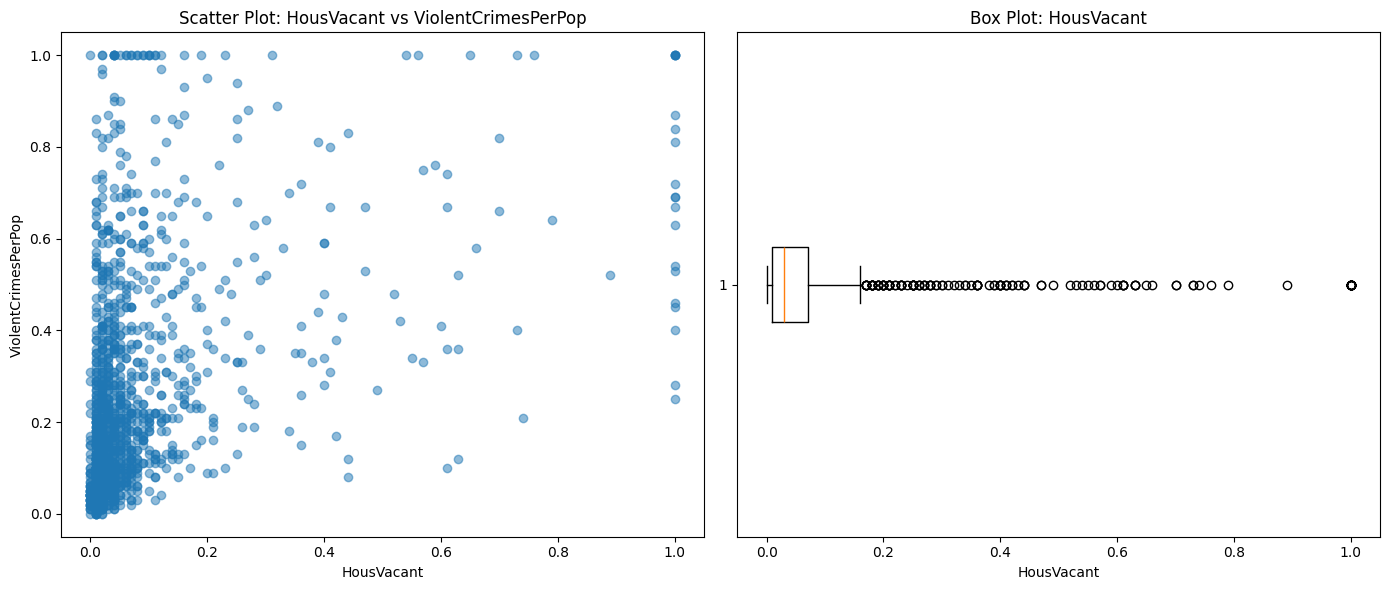

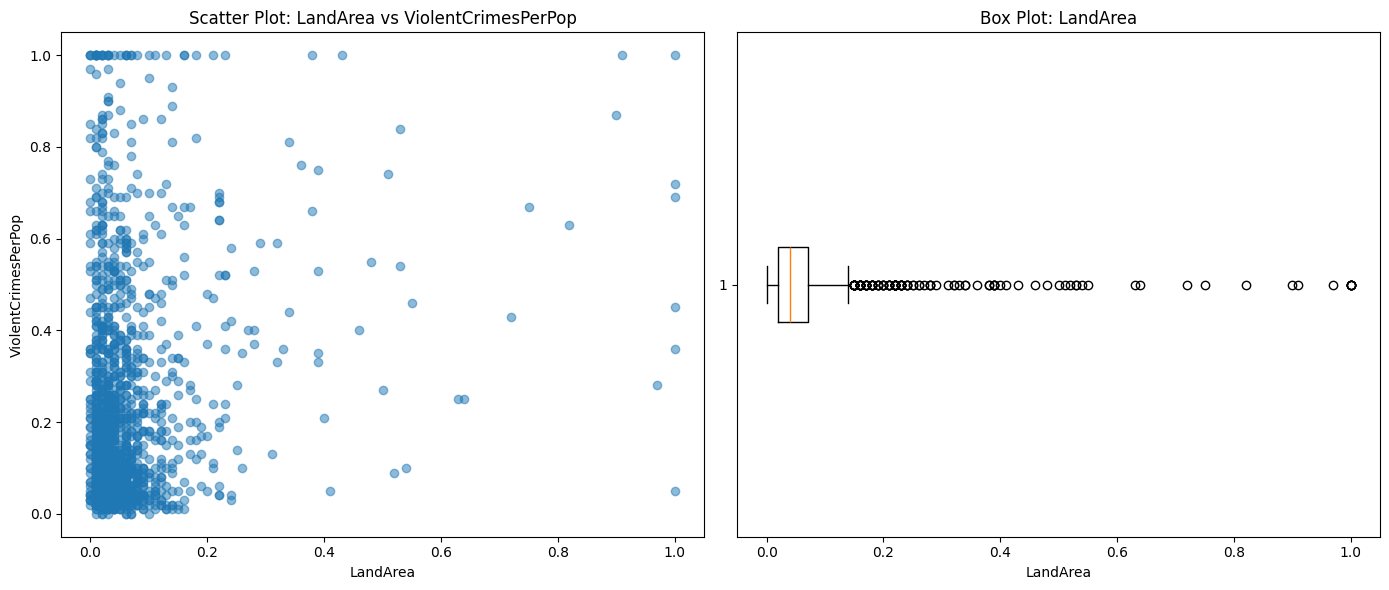

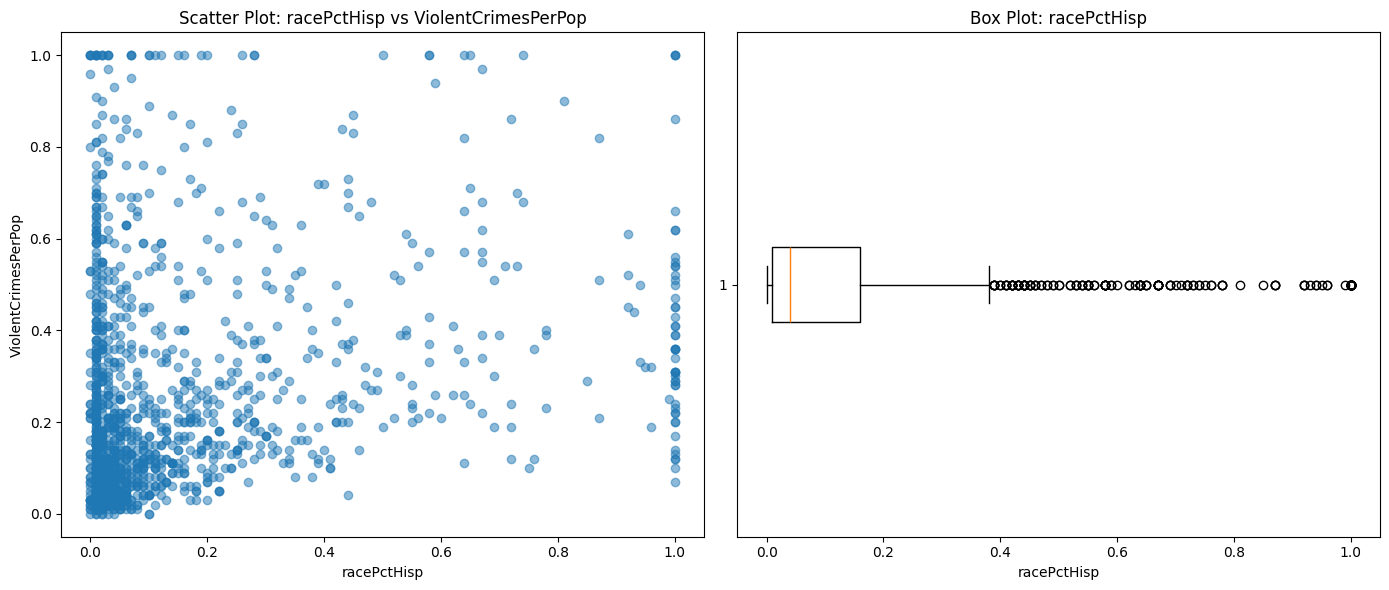

In [126]:
# Select the top 11 features with the highest CV
top_cv_features = cv.nlargest(11).index

# Create scatter plots and box plots for these features
for feature in top_cv_features:
    plt.figure(figsize=(14, 6))

    # Scatter Plot
    plt.subplot(1, 2, 1)
    plt.scatter(train_df[feature], train_df['ViolentCrimesPerPop'], alpha=0.5)
    plt.xlabel(feature)
    plt.ylabel('ViolentCrimesPerPop')
    plt.title(f'Scatter Plot: {feature} vs ViolentCrimesPerPop')

    # Box Plot
    plt.subplot(1, 2, 2)
    plt.boxplot(train_df[feature], vert=False)
    plt.title(f'Box Plot: {feature}')
    plt.xlabel(feature)

    plt.tight_layout()
    plt.show()

(f) Fit a linear model using least squares to the training set and report the test error.

In [127]:
# Separate features and target variable
X_train = train_df.drop(columns=['ViolentCrimesPerPop'])
y_train = train_df['ViolentCrimesPerPop']
X_test = test_df.drop(columns=['ViolentCrimesPerPop'])
y_test = test_df['ViolentCrimesPerPop']

# Fit the linear regression model
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

# Predict on the test set
y_pred_linear = linear_model.predict(X_test)

# Calculate the test error (MSE)
linear_mse = mean_squared_error(y_test, y_pred_linear)
print(f"Linear Regression Test MSE: {linear_mse}")

Linear Regression Test MSE: 0.7897255274384746


(g) Fit a ridge regression model on the training set, with $\lambda$ chosen by cross-validation. Report the test error obtained.

Anser: Cross-Validation and RidgeCV: **RidgeCV performs cross-validation to select the optimal lambda value**. It's crucial to choose an appropriate range of alphas to explore. By comparing the test MSE from both models, I can determine which model better generalizes to new data in this context. The lower the MSE, the better the model is at predicting the target variable.

In [130]:
# Define a range of alphas (lambda values) to try
alphas = [0.1, 1.0, 10.0, 100.0, 200.0]

# Fit Ridge Regression using cross-validation to choose the best lambda
ridge_model = RidgeCV(alphas=alphas, store_cv_results=True)
ridge_model.fit(X_train, y_train)

# Predict on the test set
y_pred_ridge = ridge_model.predict(X_test)

# Calculate the test error (MSE)
ridge_mse = mean_squared_error(y_test, y_pred_ridge)
print(f"Ridge Regression Test MSE: {ridge_mse}")
print(f"Best Lambda (alpha) chosen: {ridge_model.alpha_}")

Ridge Regression Test MSE: 0.017737081104305975
Best Lambda (alpha) chosen: 1.0


(h) Fit a LASSO model on the training set, with $\lambda$ chosen by cross-validation. Report the test error obtained, along with a list of the variables selected by the model. Repeat with standardized features. (In this data set, features are already normalized) Report the test error for both cases and compare them.

Answer: we can see the Test MSE without Standardization is 0.017763310017858244, which is slightly smaller than the test MSE with Standardization: 0.017810499483270535. So there is no guarantee that the standardization can help improve the accuracy of Lasso Regression Model.

In [133]:
# LASSO without explicit standardization
lasso_cv = LassoCV(cv=5, random_state=0, max_iter=5000, tol=1e-4)
lasso_cv.fit(X_train, y_train)

# Predict and evaluate the test error
y_pred_lasso = lasso_cv.predict(X_test)
lasso_mse = mean_squared_error(y_test, y_pred_lasso)

# Get the list of variables selected by LASSO
lasso_selected_features = X_train.columns[lasso_cv.coef_ != 0].tolist()

print("LASSO Test MSE without Standardization:", lasso_mse)
print("LASSO Selected Variables:", lasso_selected_features)

# LASSO with Standardization
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

lasso_cv_standardized = LassoCV(cv=5, random_state=0, max_iter=5000, tol=1e-4)
lasso_cv_standardized.fit(X_train_scaled, y_train)

# Predict and evaluate the test error
y_pred_lasso_std = lasso_cv_standardized.predict(X_test_scaled)
lasso_mse_std = mean_squared_error(y_test, y_pred_lasso_std)

# Get the list of variables selected by LASSO
lasso_selected_features_std = X_train.columns[lasso_cv_standardized.coef_ != 0].tolist()

print("LASSO Test MSE with Standardization:", lasso_mse_std)
print("LASSO Selected Variables with Standardization:", lasso_selected_features_std)

LASSO Test MSE without Standardization: 0.017763310017858244
LASSO Selected Variables: ['racepctblack', 'racePctAsian', 'agePct12t21', 'agePct12t29', 'pctUrban', 'pctWWage', 'pctWFarmSelf', 'pctWInvInc', 'pctWSocSec', 'pctWPubAsst', 'pctWRetire', 'whitePerCap', 'blackPerCap', 'indianPerCap', 'AsianPerCap', 'OtherPerCap', 'HispPerCap', 'PctPopUnderPov', 'PctLess9thGrade', 'PctEmploy', 'PctEmplManu', 'PctOccupManu', 'MalePctDivorce', 'MalePctNevMarr', 'FemalePctDiv', 'PctKids2Par', 'PctYoungKids2Par', 'PctTeen2Par', 'PctWorkMom', 'NumIlleg', 'PctIlleg', 'NumImmig', 'PctImmigRec10', 'PctRecImmig10', 'PctNotSpeakEnglWell', 'PctLargHouseOccup', 'PersPerOccupHous', 'PctPersOwnOccup', 'PctPersDenseHous', 'PctHousLess3BR', 'MedNumBR', 'HousVacant', 'PctHousOccup', 'PctVacantBoarded', 'PctVacMore6Mos', 'MedYrHousBuilt', 'PctHousNoPhone', 'PctWOFullPlumb', 'OwnOccLowQuart', 'RentLowQ', 'MedRent', 'MedRentPctHousInc', 'MedOwnCostPctInc', 'MedOwnCostPctIncNoMtg', 'NumInShelters', 'NumStreet', 'Pct

(i) Fit a PCR model on the training set, with M (the number of principal components) chosen by cross-validation. Report the test error obtained.

In [136]:
# Explore different numbers of components
m_values = range(1, X_train.shape[1] + 1)
cv_errors = []

for m in m_values:
    # Perform PCA
    pca = PCA(n_components=m)
    X_train_pca = pca.fit_transform(X_train)

    # Fit the linear regression model using CV to determine cross-validated error
    linear_model = LinearRegression()
    mse_scores = cross_val_score(linear_model, X_train_pca, y_train, cv=5, scoring='neg_mean_squared_error')

    # Average CV error for this number of components
    cv_errors.append(-mse_scores.mean())

# Select the number of components that gives the minimum CV error
best_m = np.argmin(cv_errors) + 1
print(f'Best number of principal components: {best_m}')

# Fit the PCR model with the best number of components
pca = PCA(n_components=best_m)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

linear_model = LinearRegression()
linear_model.fit(X_train_pca, y_train)

# Predict and calculate test error
y_pred_pcr = linear_model.predict(X_test_pca)
pcr_test_mse = mean_squared_error(y_test, y_pred_pcr)
print(f'PCR Test MSE with {best_m} components: {pcr_test_mse}')

Best number of principal components: 96
PCR Test MSE with 96 components: 0.018480440216198477


(j) In this section, we would like to fit a boosting tree to the data. As in classification trees, one can use any type of regression at each node to build a multivariate regression tree. Because the number of variables is large in this problem, one can use L1-penalized regression at each node. Such a tree is called L1 penalized gradient boosting tree. You can use XGBoost to fit the model tree. Determine $\lambda$ (the regularization term) using cross-validation.

Answer: In **xgboost $\alpha$ controls L1 regularization, while $\lambda$ controls L2 regularization**, because we are required to use L1-penalized regression, so I think we should determine best $\alpha$ for L1 regularization term using cross-validation.

In [149]:
# Convert data into DMatrix format (XGBoost's optimized data structure)
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Define the base parameters (you can adjust as needed)
params = {
    'booster': 'gbtree',
    'objective': 'reg:squarederror',  # For regression tasks
}

# Lambda (alpha) values to test
alpha_values = [0.01, 0.1, 1, 10, 100]

# Use cross-validation to find the best alpha
cv_results = []
for alpha in alpha_values:
    params['alpha'] = alpha # alpha is the L1 regularization term, lambda is the L2 regularization term
    cv = xgb.cv(
        params,
        dtrain,
        num_boost_round=100,
        nfold=5,
        metrics='rmse',
        as_pandas=True,
        seed=42
    )
    mean_rmse = cv['test-rmse-mean'].min()
    cv_results.append((alpha, mean_rmse))

# Find the best alpha
best_alpha, best_rmse = min(cv_results, key=lambda x: x[1])
print(f'Best alpha: {best_alpha}, Best RMSE: {best_rmse}')

# Update the parameters with the best alpha
params['alpha'] = best_alpha

# Train the final model
model = xgb.train(params, dtrain, num_boost_round=100)

# Predict on the test set
y_pred_xgb = model.predict(dtest)

# Calculate the test error
xgb_test_mse = mean_squared_error(y_test, y_pred_xgb)
print(f'XGBoost L1-Penalized Test MSE: {xgb_test_mse}')


Best alpha: 1, Best RMSE: 0.14583716676100447
XGBoost L1-Penalized Test MSE: 0.01775752449552266
